# Analysis of Sea Level Rise in Maryland
#### Valerie Caplan, Gabriel Wittman

### Introduction:
Sea Level Rise poses a serious risk to the state of Maryland since Maryland is a coastal state. An increase in the sea level leads to more frequent and higher flooding which can affect anyone and anything near the coastline [(source)](https://tidesandcurrents.noaa.gov/publications/NOAA_Technical_Report_NOS_COOPS_073.pdf). One specific example of an entity being affected by the effects of sea level rise is the United States Naval Academy in Annapolis, MD, where the rise in sea level has “significantly increased the occurrences of nuisance flooding”  [(source)](https://www.usna.edu/PAO/documents/USNA_SLRAC_Report_to_Superintendent_FINAL_190716.pdf). 

Other risks posed by sea level rise include shore erosion, inundation, raising water tables, and saltwater intrusion [(source)](https://dnr.maryland.gov/ccs/Publication/Annapolis_RRSLRnSSI.pdf). Many scientists and Marylanders understand the risk posed by the changing nature of our coastal waters, and this has resulted in the creation of organizations such as the [Maryland Sea Grant Extension Coastal Climate Program](https://extension.umd.edu/programs/environment-natural-resources/program-areas/coastal-climate-program). The [Maryland Department of Natural Resources CoastSmart Resource Center](https://dnr.maryland.gov/ccs/coastsmart/Pages/cs_Resources.aspx) has also increased their efforts related to sea level rise in recent years. 

In this project we plan to analyze sea level data in Maryland and other related oceanic and atmospheric data. 

### The Data Source
For the sea level data, we chose to use monthly mean sea level data recorded at the NOAA Tides & Currents [Annapolis, MD station](https://tidesandcurrents.noaa.gov/stationhome.html?id=8575512). We chose this station specifically because it has been taking measurements consistently for nearly 100 years which will enable us to better analyze long term trends. We accessed this data through the CO-OPS (Center for Operational Oceanographic Products and Services) [API](https://api.tidesandcurrents.noaa.gov/api/prod/). 

For weather data we chose to use data available on the Desert Research Institute's Western Regiounal Climate Center [website](https://wrcc.dri.edu/summary/de_mdF.html). The specific data set that we used recorded monthly average temperatures at the [Glenn Dale Bell Station](https://wrcc.dri.edu/WRCCWrappers.py?sodxtrmts+183675+por+por+avgt+none+mave+5+01+F). We chose to use data from this station because it recorded data relatively consistently for nearly 100 years and the station is located less than 25 miles from the NOAA Tides & Currents Annapolis, MD station.

### Processing and Storing the Data

First, we start by importing libraries that will be relevant for our analysis. 

In [1]:
# Libraries used to access and extract the data
import requests
import json
from bs4 import BeautifulSoup

# Standard Python libraries for data science
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

# Python libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

Next we use the CO-OPS API to get the monthly sea level data recorded at the Annapolis station between 1930 and 2020. 

In [2]:
# Request the data from the API in the json format, and store the retrieved data in a Pandas dataframe
url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=19300101&end_date=20200101&station=8575512&product=monthly_mean&datum=MSL&time_zone=lst&units=english&format=json'
r = requests.get(url)
json_data = r.json()
data_df = pd.DataFrame(json_data["data"])

# Display a sample of what the dataframe looks like in its current form 
data_df.head()

,year,month,highest,MHHW,MHW,MSL,MTL,MLW,MLLW,DTL,GT,MN,DHQ,DLQ,HWI,LWI,lowest,inferred
0,1930,1,0.764,,-0.745,-1.135,-1.155,-1.565,,,,0.820,,,10.370,3.980,-2.835,0
1,1930,2,0.564,,-0.577,-0.978,-0.978,-1.388,,,,0.810,,,10.130,4.100,-3.136,0
2,1930,3,1.263,,-0.636,-1.037,-1.056,-1.476,,,,0.840,,,10.240,4.110,-3.136,0
3,1930,4,0.663,,-0.607,-0.978,-0.978,-1.345,,,,0.741,,,10.080,4.080,-2.835,0
4,1930,5,0.663,,-0.525,-0.935,-0.935,-1.345,,,,0.820,,,10.070,3.940,-2.238,0


In the dataframe, many values are recorded but the primary parameter of interest to our analysis is MSL which represents the Mean Sea Level recorded for the given month. Now we will create a dataframe with only a subset of these available columns related to parameters we wish to explore in our analysis. Explanations of the other accronyms can be found [here](https://tidesandcurrents.noaa.gov/datum_options.html).

In [3]:
# Add a new column to store the data point's month with respect to January 1930
data_df.insert(18, 'month_num', 0, allow_duplicates=True)

# For each row add its month number to the month_num column
for index,row in data_df.iterrows():
    data_df.iat[index, 18] = index + 1

# Extract a subset of the columns from the dataframe into a new dataframe called msl_df
msl_df = data_df[['year','month', 'MSL', 'MTL', 'month_num', 'MHW']].copy()

# Convert all columns from storing objects to numeric types
msl_df['year'] = pd.to_numeric(msl_df['year'], errors='coerce')
msl_df['month'] = pd.to_numeric(msl_df['month'], errors='coerce')
msl_df['MSL'] = pd.to_numeric(msl_df['MSL'], errors='coerce')
msl_df['MTL'] = pd.to_numeric(msl_df['MTL'], errors='coerce')
msl_df['MHW'] = pd.to_numeric(msl_df['MHW'], errors='coerce')

# Drop any rows that contain a missing value (necessary for using LinearRegression().fit())
msl_df.dropna(inplace=True)

# There is only one single data point recorded in 2020, so we drop it so it won't interfere with yearly measurments
msl_df.drop(index = 1040, inplace=True)

# Here is a sample of what the new streamlined dataframe looks like
msl_df.head()

,year,month,MSL,MTL,month_num,MHW
0,1930,1,-1.135,-1.155,1,-0.745
1,1930,2,-0.978,-0.978,2,-0.577
2,1930,3,-1.037,-1.056,3,-0.636
3,1930,4,-0.978,-0.978,4,-0.607
4,1930,5,-0.935,-0.935,5,-0.525


Next, let us turn to extracting and cleaning the weather data from the Glenn Dale Bell Station.

In [4]:
# Use requests and beautiful soup to extract the table into a pandas dataframe
page = requests.get('https://wrcc.dri.edu/WRCCWrappers.py?sodxtrmts+183675+por+por+avgt+none+mave+5+01+F')
bs = BeautifulSoup(page.text,'html.parser')
the_table = bs.find('table')
pretty_table = the_table.prettify()
df_list = pd.read_html(str(pretty_table))
temperature_df = df_list[0]

# Here is what the dataframe looks like in its current form
temperature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,YEAR(S),JAN,JAN,FEB,FEB,MAR,MAR,APR,APR,MAY,...,SEP,SEP,OCT,OCT,NOV,NOV,DEC,DEC,ANN,ANN
1,1921,35.05,NaN,37.59,NaN,55.02,a,59.00,NaN,61.80,...,73.55,a,54.83,a,47.31,a,36.07,a,56.97,NaN
2,1922,29.78,a,37.05,NaN,44.18,NaN,54.18,b,64.50,...,68.07,NaN,57.08,NaN,44.57,NaN,35.50,NaN,54.60,NaN
3,1923,34.23,a,30.69,b,44.74,NaN,51.62,NaN,61.06,...,68.72,NaN,54.53,NaN,43.17,NaN,43.20,a,54.41,NaN
4,1924,34.57,a,32.28,NaN,41.87,NaN,49.95,NaN,59.56,...,63.50,a,54.95,NaN,44.28,NaN,34.77,NaN,52.70,NaN


This is on the right track, but definitely needs some substantial work done to clean it up.

In [5]:
# Drop unneccesary columns from the dataframe
temperature_df.drop([x for x in range(2, 25, 2)] , axis=1, inplace=True)
temperature_df.drop([25, 26], axis=1, inplace=True)

# Rename the column and row labels
temperature_df.set_axis(temperature_df.loc[0], axis='columns', inplace=True)
temperature_df.rename(index=temperature_df['YEAR(S)'], inplace=True)
temperature_df.drop(['YEAR(S)'], axis=1, inplace=True)
temperature_df.drop(['YEAR(S)'], inplace=True)

# Convert each column from an object to a numerical type
for i in range(12):
    temperature_df[temperature_df.columns[i]] = pd.to_numeric(temperature_df[temperature_df.columns[i]], errors='coerce')

# Drop the bottom rows that the were accidentally included
temperature_df = temperature_df.drop(temperature_df.tail(8).index)

# Add a column for the years average temperature
temperature_df.insert(12, 'year_avg', 0.0, allow_duplicates=True)
for index, row in temperature_df.iterrows():
    row['year_avg'] = row.mean()
    
# Add a column to store the numeric years
temperature_df.insert(13, 'year', 0, allow_duplicates=True)
temperature_df['year'] = pd.to_numeric(temperature_df.index, errors='coerce')
temperature_df.head()

# Here is what the dataframe now looks like in its new and more organized form
temperature_df.head()

/tmp/ipykernel_38830/488483815.py:6: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  temperature_df.set_axis(temperature_df.loc[0], axis='columns', inplace=True)


,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,year_avg,year
1921,35.05,37.59,55.02,59.00,61.80,73.40,78.35,71.68,73.55,54.83,47.31,36.07,52.588462,1921
1922,29.78,37.05,44.18,54.18,64.50,73.32,75.56,71.40,68.07,57.08,44.57,35.50,50.399231,1922
1923,34.23,30.69,44.74,51.62,61.06,73.63,74.00,73.33,68.72,54.53,43.17,43.20,50.224615,1923
1924,34.57,32.28,41.87,49.95,59.56,70.00,73.19,73.44,63.50,54.95,44.28,34.77,48.643077,1924
1925,29.77,40.80,45.00,54.75,57.87,76.10,75.31,71.24,72.14,51.27,42.23,34.60,50.083077,1925


This definitely significantly better. Note that we chose to also add a yearly average temperature column since temperatures fluctuate significantly seasonally and our analysis is centered around longer term trends. Now that we have all relevant data accessible in pandas dataframes, we can move on to exploring this data. 

### Exploratory Data Analysis and Visualization

First, lets make a scatter plot tracking the monthly Mean Sea Level over time to see if there's any obvious relationship present in this dataset. The Mean Sea Level measurements are in meters and are relative to the [Mean Sea Level Datum established by CO-OPS](https://tidesandcurrents.noaa.gov/datum_options.html).

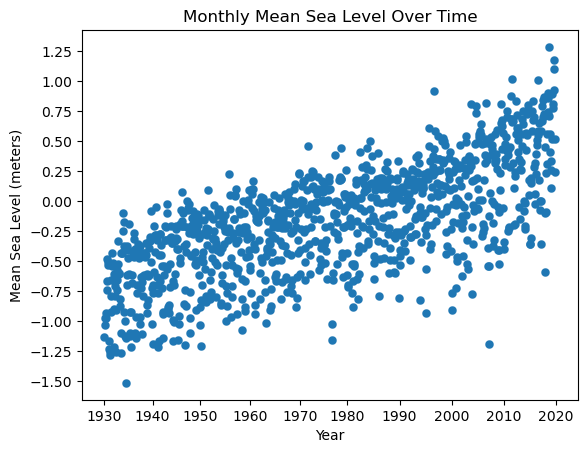

In [6]:
# Create a scatter plot with Mean Sea Level on the y axis and month with respect to January 1930 on the x axis
plt.scatter(msl_df['month_num'], msl_df['MSL'], linewidths=.1)

# Add labels to the plot
plt.xlabel("Year")
plt.ylabel("Mean Sea Level (meters)")
plt.title("Monthly Mean Sea Level Over Time")

# Add specific sea level ticks to the y axis
plt.yticks(np.arange(-1.5, 1.5, step=0.25))

# Add the specific years to the x axis
plt.xticks([1,112,222,336,451,561,681,801,921,1041],[1930,1940,1950,1960,1970,1980,1990,2000,2010,2020])

# Display the plot
plt.show()

From this plot there appears to be a linear relationship between time and the MSL recorded at the Annapolis station. To better see this trend, we now create the same plot with a regression line added.

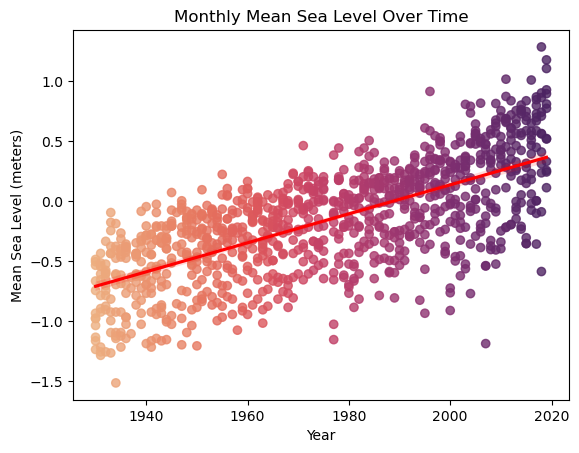

In [7]:
# Use Seaborn's regplot function to create the same scatter plot with a linear regression line added
sns.regplot(x = "year", y = "MSL", data = msl_df, scatter_kws={"color": sns.color_palette("flare", n_colors = 1037)}, line_kws={"color": "red"})

# Add labels to the scatter plot
plt.title("Monthly Mean Sea Level Over Time")
plt.xlabel("Year")
plt.ylabel("Mean Sea Level (meters)")

# Display the current plot 
plt.show()

The regression line shown above does seem to match our intuition, and we will explore this relationship more later. First, we want to explore any possible relationships between MSL and other monthly measurements, such as MTL (Mean Tide Level), and MHW (Mean High Water).

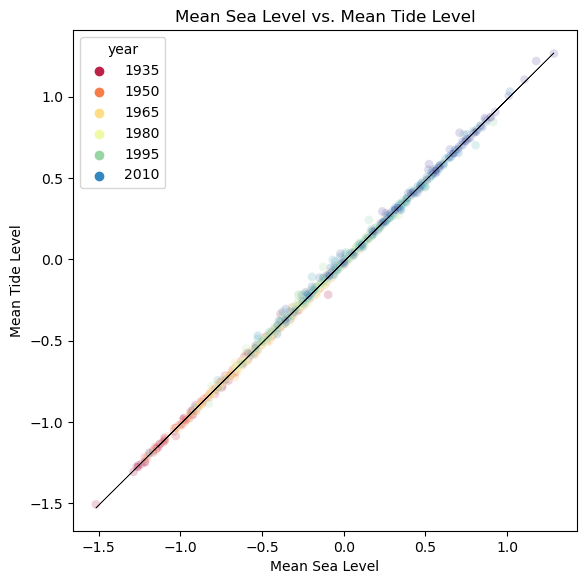

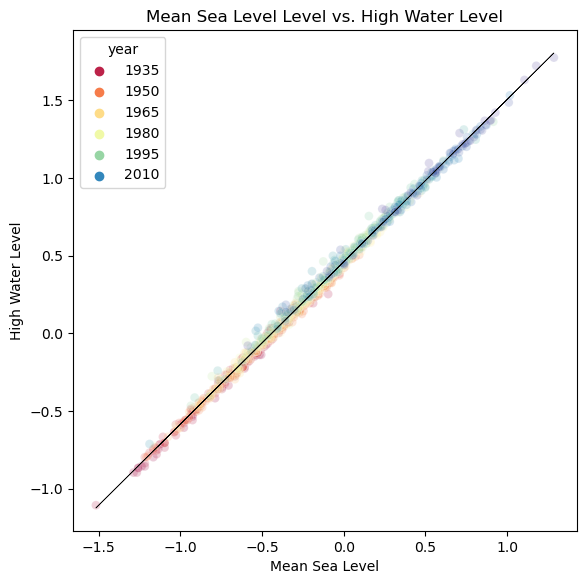

In [8]:
# Create a scatter plot with the Mean Sea Level on the x axis and the Mean Tide Level on the y axis
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x="MSL", y="MTL", hue="year",
                palette="Spectral",
                alpha=0.2, s = 40,
                data=msl_df, ax=ax)

# Add labels to the scatter plot 
plt.title("Mean Sea Level vs. Mean Tide Level")
plt.xlabel("Mean Sea Level")
plt.ylabel("Mean Tide Level")

# Fit a linear regression model for MTL vs MSL using the Linear regression function from scikit-learn
x = msl_df['MSL'].to_numpy().reshape(-1,1)
y = msl_df['MTL'].to_numpy()
model = LinearRegression().fit(x,y)
plt.plot(x, model.predict(x), color='black', linewidth=.5)

# Display this first plot
plt.show()

# Create a scatter plot with Mean Sea Level on the x axis and the Mean High Water on the y axis
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x="MSL", y="MHW", hue="year",
                palette="Spectral",
                alpha=0.2, s = 40,
                data=msl_df, ax=ax)

# Add labels to the scatter plot
plt.title("Mean Sea Level Level vs. High Water Level")
plt.xlabel("Mean Sea Level")
plt.ylabel("High Water Level")

# Fit a linear regression model for MHW vs MSL using the Linear regression function from scikit-learn
x = msl_df['MSL'].to_numpy().reshape(-1,1)
y = msl_df['MHW'].to_numpy()
model2 = LinearRegression().fit(x,y)
plt.plot(x, model2.predict(x), color='black', linewidth=.5)

# Display this second plot
plt.show()

The first figure shown above is a comparison of the MSL: Monthly Sea Level and the MHW: Monthly Tide Level data for every month from 1930-2019. Both figures demonstrate a strong, linear relationship between MSL and the MTL or the MHW. The palette used for these figures is meant to demonstrate how the measurements have changed over time. The earlier the year, the closer to the "start" of the rainbow the color is. So, 1930 is red and 2010 is blue. As you can see, in both graphs, the older (red) data points are near the bottom left of the graph, and the newer (blue/purple) data points are near the top right. This suggests that as time increases, the water level and tide level increase at an approximate 1 to 1 rate. 

Due to the way the dots are not as close to the line in the the second figure (MSL vs MHW) compared to the first (MSL vs MTL), we can conclude there is slightly more variance in the relationship between MSL and MHW. This could mean that the High Water Level is slightly less correlated to the Mean Sea Level, however this difference in correlation appears to be very small (and rather insignificant). 

These graphs do not display any unexpected relationships, and we will now return to analyzing the relationship between the MSL and time. 

In the first figure shown, the Mean Sea Level Over Time scatter plot, it can be seen that a significant amount of variation exists within individual years. This is because the sea level generally follows a seasonal cycle. This can be attributed to a number of factors, some being that water expands when it is warmer and seasonal weather patterns effects on ocean currents [(source)](https://research.csiro.au/slrwavescoast/sea-level/sea-level-change/#:~:text=Seasonal%20changes,in%20winter%20and%20early%20spring). Therefore, to analyze the true trend in the sea level over time, we need to remove this variation from our data set, and we will do this by calculating yearly averages (by averaging the monthly means within each given year). 

However, before we do this, we will plot the data with the monthly measurements using violin plots for each decade to see if there are any changes in the seasonal variations over time. 

The reason we are choosing the make each violin represent a decade is due to the physical space limitations of a computer display: if we tried to make a violin plot for each year, 1930 to 2019, it would be unreadable. 

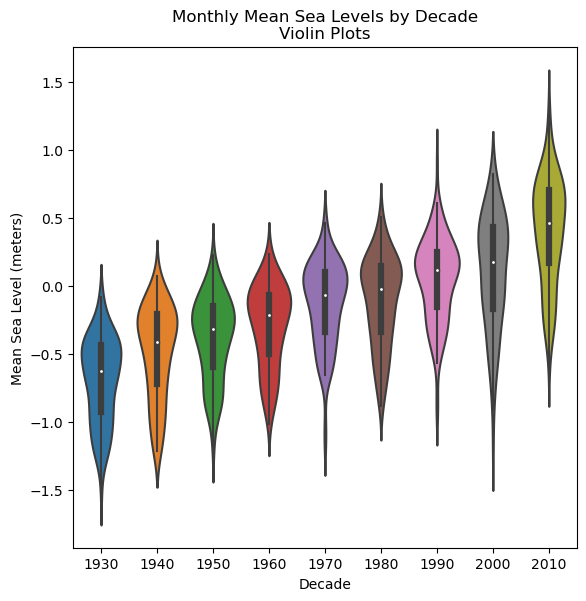

In [9]:
# Create a decade column in the msl_df dataframe
msl_df['decade'] = msl_df['year'].apply(lambda year: int(str(year)[:3] + '0'))

# Create violin plots for each decades monthly MSL measurments 
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.violinplot(x = 'decade', y = 'MSL', data = msl_df, ax=ax)

# Add labels to the violin plot
plt.title("Monthly Mean Sea Levels by Decade\nViolin Plots")
plt.xlabel("Decade")
plt.ylabel("Mean Sea Level (meters)")

# Display the plot
plt.show()

From this plot it appears that the amount of variation in MSL has increased over the past 100 years. Perhaps this is related to the notable changes in climate variability attributed to climate change, as oceans and the climate have a ["two-way relationship"](https://www.epa.gov/climate-indicators/oceans). 

Now we will calculate the average MSLs for each year.

In [10]:
# Find the mean MSL across all months for each given year in the msl_df dataframe
msl_year_means = msl_df.groupby('year')['MSL'].mean().to_frame()
msl_year_means['year'] = msl_year_means.index
msl_year_means.index.names = ['index']

# Here is a sample of what this new series looks like 
msl_year_means.head()

,MSL,year
index,,
1930,-0.866833,1930
1931,-0.805167,1931
1932,-0.714417,1932
1933,-0.608667,1933
1934,-0.764500,1934


Now lets plot these yearly mean MSLs over time.

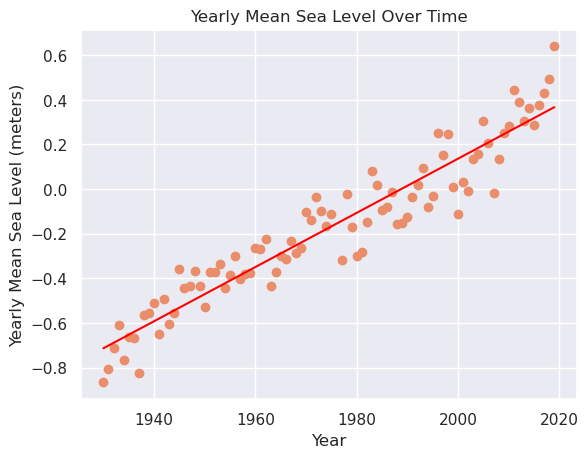

In [11]:
sns.set_theme(palette = 'flare')

# Create a scatter plot tracking yearly mean (calculated from the monthly means)
plt.scatter(msl_year_means['year'], msl_year_means['MSL'])

# Fit a linear regression model for Yearly MSL vs Year using the Linear regression function from scikit-learn
x = msl_year_means['year'].to_numpy().reshape(-1,1)
y = msl_year_means['MSL'].to_numpy()
model = LinearRegression().fit(x,y)
plt.plot(x, model.predict(x), color='r')

# Add labels to the plot
plt.xlabel("Year")
plt.ylabel("Yearly Mean Sea Level (meters)")
plt.title("Yearly Mean Sea Level Over Time")

# Display the plot
plt.show()

Luckily, when we plot the yearly Mean Sea Levels over time, the positive linear trend is just as (if not more) apparent then when we plotted the monthly Mean Sea Levels.

Next, we will explore the weather dataframe present in the temperature_df dataframe. We will start by creating a scatter plot of the yearly average temperatures over time. 

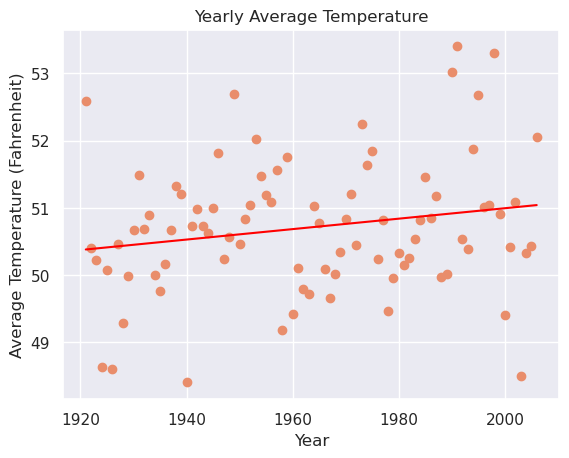

In [12]:
# Make a scatter plot tracking yearly average temperature over time
plt.scatter(temperature_df['year'], temperature_df['year_avg'])

# Fit a regression line on the yearly average temperatures over time
x = temperature_df['year'].to_numpy().reshape(-1,1)
y = temperature_df['year_avg'].to_numpy()
model = LinearRegression().fit(x,y)
plt.plot(x, model.predict(x), color='r')

# Add labels to the plot
plt.xlabel("Year")
plt.ylabel("Average Temperature (Fahrenheit)")
plt.title("Yearly Average Temperature")

# Display the plot
plt.show()

While there does appear to possibly be a slight increase in yearly mean temperature over time, the relationship does not seem strong, since the yearly average temperatures appears so variable. We were curious if a notable trend in the yearly average temperatures would be measurable in Maryland from this data source, because this would enable us to do multivariate linear regression to predict the Mean Sea Level based on the year and year's average temperature. Visually, it seems like there is only a very weak relationship, however we will still test models based on temperature in order to confirm this.

### Deriving Insights using Statistics and ML

To further test our theory of there being a linear relationship between Mean Sea Level and time, below we employ hypothesis testing with OLS (ordinary least squares). This will help us determine whether there is truly a relationship between year and the sea level.

In [13]:
# Calculate least squares result with OLS function from the Stats Models Formula API
ols_year_results = smf.ols(formula="MSL ~ year", data=msl_year_means).fit()
print (ols_year_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    MSL   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     803.4
Date:                Thu, 11 May 2023   Prob (F-statistic):           1.04e-45
Time:                        23:24:13   Log-Likelihood:                 74.800
No. Observations:                  89   AIC:                            -145.6
Df Residuals:                      87   BIC:                            -140.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -24.1548      0.846    -28.546      0.0

We can use the information above in our hypothesis testing. The null hypothesis is that there is no relationship between year and MSL. To reject the null hypothesis, we need to determine that the p value is < 0.05. Since in the output above, P > |t| is listed as 0.00, we can confidently conclude to reject the null hypothesis that there is no relationship between year and water level, meaning that there is a relationship between these two variables. Here the f-statistic for relating MSL to year is listed as 803.4. The f-statistic determines how good the model does in explaining the variance between year and mean sea level, and a f-statistic of 803.4 is quite high, meaning this is a good model.

Next, we will use this model to plot the residuals versus the fitted values. This plot will help us further analyze this model.

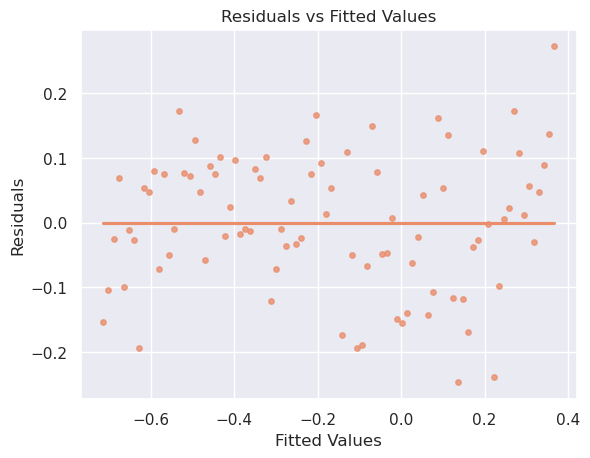

In [14]:
# Get the fitted values and residuals from the model
fitted = ols_year_results.fittedvalues
residuals = ols_year_results.resid

# Create the scatter plot with the regression line for clarity
sns.regplot(x = "Fitted Values", y = "Residuals", data = {'Fitted Values': fitted, 'Residuals': residuals}, scatter_kws={'s':15}, ci = 0)

# Add labels and title
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')

# Display the plot
plt.show()

Above, we have the fitted values produced by the model plotted against their corresponding residuals. The data points in this plot appear to “bounce randomly” while being centered around the 0 line, which suggests that our assumption of the relationship being linear is reasonable [(source)](https://online.stat.psu.edu/stat462/node/117/). As well, in this plot we can observe that there do not seem to be many outliers.

Now we will turn to exploring the yearly weather data. We will first try fitting a multivariate linear regression model on the data that predicts the yearly Mean Sea Level based on the year and the given year's average temperature.

In [15]:
# Inner join the yearly average temperature data with the yearly mean sea level data on year
year_temp_means = temperature_df[['year', 'year_avg']].copy()
join_result = year_temp_means.merge(msl_year_means, on='year', how='inner')

# Here is a sample of what the dataframe containing the results of the inner join looks like
join_result.head()

,year,year_avg,MSL
0,1930,50.670769,-0.866833
1,1931,51.485385,-0.805167
2,1932,50.686923,-0.714417
3,1933,50.894615,-0.608667
4,1934,49.996923,-0.764500


We use inner join here because we want the model to predict the Mean Sea Level based on both the year and the average temperature for the given year. Now that we have joined the data sets we can find the OLS regression results.

In [16]:
# Calculate least squares result with OLS where year and temperature are used to predice the MSL
ols_year_and_temp = smf.ols(formula="MSL ~ year + year_avg", data=join_result).fit()
print(ols_year_and_temp.summary())

                            OLS Regression Results                            
Dep. Variable:                    MSL   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     249.2
Date:                Thu, 11 May 2023   Prob (F-statistic):           2.41e-33
Time:                        23:24:14   Log-Likelihood:                 69.188
No. Observations:                  76   AIC:                            -132.4
Df Residuals:                      73   BIC:                            -125.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.0815      1.124    -20.541      0.0

These results show us that our earlier intuition was correct. Adding the yearly average temperature to the model does not improve the accuracy of the model's predictions. This is apparent because of the year_avg having a high p value of 0.387 which is much too high for us to reject the null hypothesis of no relationship. 

Comparing these two models, the single variable model that predicts the sea level based on the just the year alone  is much better. In this model all features have a relationship with the dependent variable. This first model has a f value of 803, which is much better than the second model's f value of 249. 

Next, we will play around with normalization. First, we are going to normalize the features (columns) of the data, and then create a model using that normalized data. We expect to get the same model as the one above, because a property of linear regression is that normalization shouldn't affect the resulting p and f values. This is because the coefficients will take care of the "relative importance" of the features.

In [17]:
# Create the normalized array using preprocessing from sklearn
# Axis=0 option normalizes across each column
d = preprocessing.normalize(join_result, axis=0)
scaled_cols = pd.DataFrame(d, columns=join_result.columns)

# Here is a sample of what the dataframe containing the normalized rows looks like
print(scaled_cols.head())

       year  year_avg       MSL
0  0.112492  0.114399 -0.263651
1  0.112550  0.116238 -0.244895
2  0.112608  0.114435 -0.217293
3  0.112667  0.114904 -0.185129
4  0.112725  0.112878 -0.232526


Above, we have normalized each column. Next, we will see how normalizing the columns impact the prediction below. 

In [18]:
# Calculate least squares result with OLS where normalized year and temperature are used to predice the MSL
ols_col_norm = smf.ols(formula="MSL ~ year + year_avg", data = scaled_cols).fit()
print(ols_col_norm.summary())

                            OLS Regression Results                            
Dep. Variable:                    MSL   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     249.2
Date:                Thu, 11 May 2023   Prob (F-statistic):           2.41e-33
Time:                        23:24:14   Log-Likelihood:                 159.64
No. Observations:                  76   AIC:                            -313.3
Df Residuals:                      73   BIC:                            -306.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.0203      0.342    -20.541      0.0

As you can see above, this model produces the same resulting p values and f statistic as the non-normalized model. This is as we expected, because normalization does not affect linear regression results. 

Next, we will further experiment with normalization by removing the year feature in order to produce a relationship solely between MSL and temperature. Also, in this experiment, we will try normalizing across the rows rather than across the columns as we did in the model above. This type of normalization is also called L2 normalization.

In [19]:
# Create an array with the index set as the year
msl_temp = join_result.set_index('year')

# Normalize the array by row
d = preprocessing.normalize(msl_temp, axis=1)
scaled_rows = pd.DataFrame(d, columns=msl_temp.columns)

# Here is a sample of what the dataframe containing the normalized rows looks like
print(scaled_rows.head())

   year_avg       MSL
0  0.999854 -0.017105
1  0.999878 -0.015637
2  0.999901 -0.014093
3  0.999928 -0.011958
4  0.999883 -0.015289


When we normalize across the rows, we get a very different looking result than when we normalized by columns. For each row observation, we can see that the average temperature feature's value is much higher than the MSL feature's value. A property of this type of normalization is that the square root of all of the features squared is equal to 1. Each row (observation) is essentially transformed into a unit vector. 

Next, let's see if using temperature to predict MSL is a good model.

In [20]:
# Calculate least squares result with OLS where normalized temperature is used to predice the MSL
ols_row_norm = smf.ols(formula="MSL ~ year_avg", data = scaled_rows).fit()
print(ols_row_norm.summary())

                            OLS Regression Results                            
Dep. Variable:                    MSL   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     214.6
Date:                Thu, 11 May 2023   Prob (F-statistic):           1.43e-23
Time:                        23:24:14   Log-Likelihood:                 341.09
No. Observations:                  76   AIC:                            -678.2
Df Residuals:                      74   BIC:                            -673.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -135.7187      9.263    -14.651      0.0

As you can see above, this model is not as good as our original (normalized or not normalized) model. The F-statistic is 214.6, which is less than the original models F-statistic of 249.2, which means that the original model serves as a better predictor of MSL, since it better explains the correlation between variables. Additionally, this model isn't very helpful to us anyways since our goal is to predict the change in MSL over time, and a model that does not incorporate time is not very helpful to us.

Now let's use the original year-only model to predict the Mean Sea Level in the year 2100 (Note: At the time of writing this the current year is 2023). 

In [21]:
# Use the predict function to print the predicted mean sea level in 2100
print("The predicted MSL in 2100 is: \n" + str(ols_year_results.predict({'year':2100})))

# Print the MSL in 2019 (the last year in our data set)
print("The recorded MSL in 2019 was: \n" + str(msl_year_means.loc[2019, ['MSL']]))

# Print the MSL in 1930 (the first year in our data set)
print ("The recorded MSL in 1930 was: \n" + str(msl_year_means.loc[1930, ['MSL']]))

The predicted MSL in 2100 is: 
0    1.351014
dtype: float64
The recorded MSL in 2019 was: 
MSL    0.6395
Name: 2019, dtype: float64
The recorded MSL in 1930 was: 
MSL   -0.866833
Name: 1930, dtype: float64


### Conclusion

Our model predicts that sea levels in Maryland could rise by more than two feet over the current level by 2100 if the current linear trend continues. Our model's prediction is in line with what experts predict the change between now and 2100 will be if we significantly reduce greenhouse gas emissions globally [(See the Future Sea Level Rise section)](https://www.climate.gov/news-features/understanding-climate/climate-change-global-sea-level).

This is a significant risk that deserves our attention, and action must be taken to protect both our State’s people and natural environment. It is believed that climate change (which causes ice sheets to melt) is the primary cause of the current trend in sea level rise, so reducing emissions should be a priority. It is not too late for a reduction in emissions to have an effect, and many scientists still believe that achieving the 2℃ upper limit on global warming (above pre-industrial levels) outlined in the Paris Climate Agreement is achievable through significant action [(See UMD Professor Salawitch's book)](https://link.springer.com/book/10.1007/978-3-319-46939-3).

There are also many other actions that can be taken in response to these changes to reduce the negative effects in Maryland, such as [increasing the resiliency of the coast line](https://dnr.maryland.gov/criticalarea/pages/coastal-resilience.aspx). This is very important because many homes, farms, natural habitats, and economies can be damaged.

There are many interesting and useful tools to learn more about sea level rise such as the [IPCC Sea Level Projection Tool](https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool). We also encourage you to visit this [interactive map](https://ss2.climatecentral.org/#10/38.2058/-75.8860?show=satellite&projections=0-K14_RCP85-SLR&level=1&unit=feet&pois=hide) where the risk Maryland is facing can be directly seen by inputting  the two foot increase that our model predicts will occur in the next 80 years. 